<a href="https://colab.research.google.com/github/alefram/notebooks/blob/master/pokedex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pokedex using CNN

## Colab setup

In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 31.3 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


## Import Libraries

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
    
import PIL
import random
import pathlib
import datetime
import PIL.Image

import numpy as np
import matplotlib.pyplot as plt


from datasets import load_dataset

# Data Setup

In [2]:
#Download data
ds = load_dataset("fcakyon/pokemon-classification", name="full")

In [3]:
# Usefull methods
def visualize_pokemons(images, labels, class_names):
    plt.figure(figsize=(10, 5))
    
    random_indices = np.random.choice(len(images), size=18, replace=False)

    for i, idx in enumerate(random_indices):
        ax = plt.subplot(3, 6, i + 1)
        plt.imshow(images[idx].numpy().transpose((1, 2, 0)))
        plt.title(class_names[labels[idx]])
        plt.axis("off")

In [4]:
# Define data
ds = ds.with_format("torch")
train_ds = ds['train']
test_ds = ds['test']
val_ds =  ds['validation']
class_names = train_ds.features['labels'].names

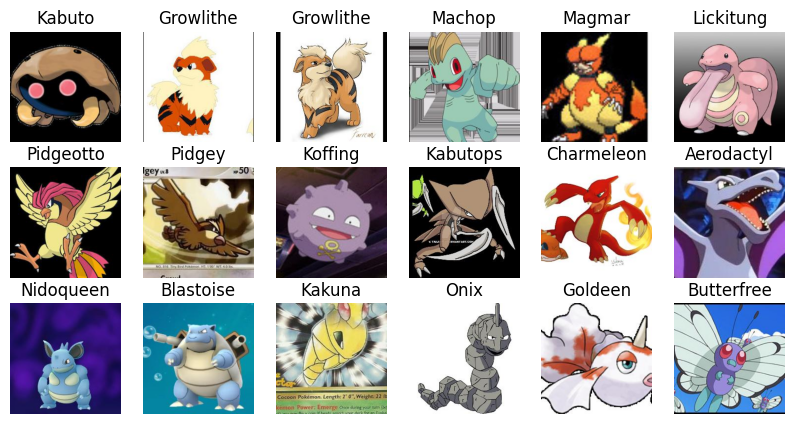

In [5]:
#visualize data
visualize_pokemons(
    images=train_ds['image'], 
    labels=train_ds['labels'], 
    class_names=class_names
) 

# Training

In [6]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [34]:
# Define neural network
class PokemonCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)   
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128*14*14, 510)
        self.fc2 = nn.Linear(510, num_classes)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = torch.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        
        return x

model = PokemonCNN(num_classes=len(class_names)).to(device)

# TESTING
# image = train_ds[0]['image']
# image = image.to(torch.float32)
# output = model(image)
# print(output.shape)
# print(model)

In [37]:
#Loss function and optimizer
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [38]:
#TODO: fix training
for epoch in range(11):
    for images, labels in train_ds:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


ValueError: too many values to unpack (expected 2)

# Evaluation

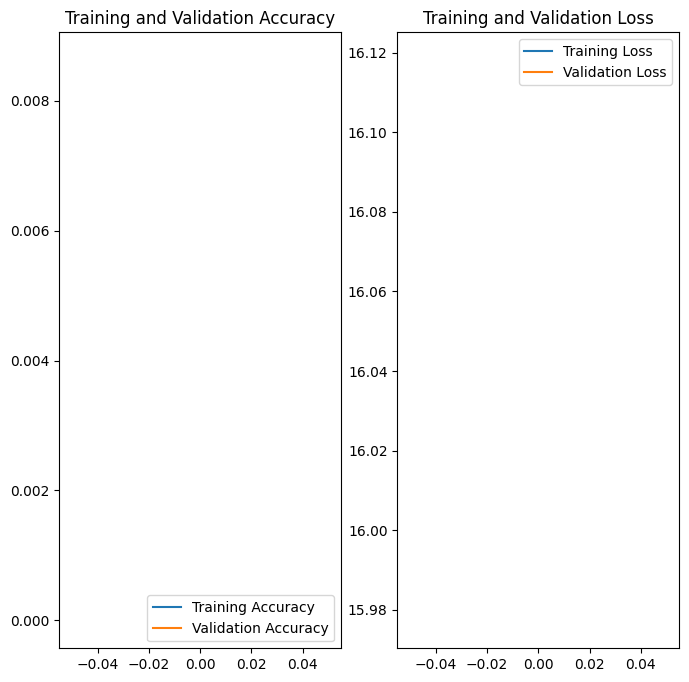

In [11]:
# TODO:Evaluate model plots


pokemon name:  Slowpoke label:  102


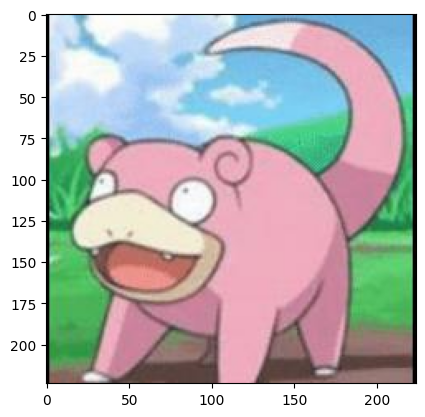

In [31]:
n = 400
image = test_ds['image'][n]
label =  test_ds['labels'][n]
print("pokemon name: ", class_names[label], "label: ", label)

plt.imshow(image.astype("uint8"))

In [32]:
#TODO: test model

This image most likely belongs to Dewgong with a 1.79 percent confidence.
